# W2V MLP

### Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import spacy
import os
import optuna
import random


from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from spacy.lang.de.stop_words import STOP_WORDS

import mlflow
import mlflow.pytorch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# If using CUDA
torch.cuda.manual_seed_all(seed)

# Define experiment
mlflow.set_experiment("W2V")
mlflow.pytorch.autolog()

### Loading data into a Dataframe (df)

In [3]:
dataframes = []
list_of_jsons = []
dir = 'data/de/'
path = os.path.join(dir, '*.dill')

files = glob.glob(path)
for file in files:
    list_of_jsons.append(pd.read_pickle(file))

for poem in list_of_jsons:
    dataframes.append(pd.DataFrame.from_dict(poem))

df = pd.concat(dataframes, ignore_index=True)

### Convertion Creation Year into a Century

In [4]:
# Convertir les dates en siècles, en gérant les valeurs None
# D'abord, créer une copie pour ne pas modifier l'original
df_siecles = df.copy()

# Convertir uniquement les valeurs non-nulles en entiers puis en siècles
# Assurons-nous que toutes les valeurs sont soit des nombres, soit des NaN
df_siecles["Creation"] = pd.to_numeric(df_siecles["Creation"], errors="coerce")

# Maintenant, appliquer la conversion en siècles seulement sur les valeurs non-nulles
mask = df_siecles["Creation"].notna()
df_siecles.loc[mask, "Creation"] = df_siecles.loc[mask, "Creation"].apply(
    lambda x: (x - 1) // 100 + 1
)

# Remplacer df par df_siecles pour conserver les modifications
df = df_siecles

### Correction des Century vides

In [5]:
# Filtrer les lignes où Creation est None
df_none_creation = df[df["Creation"].isnull()]


# Grouper par auteur pour voir combien de poèmes chaque auteur a avec Creation = None
auteurs_avec_none = (
    df_none_creation.groupby("Auteur").size().sort_values(ascending=False)
)

# Pour chaque auteur ayant des poèmes sans date, vérifier s'il a aussi des poèmes avec date
auteurs_a_corriger = []
for auteur in df_none_creation["Auteur"].unique():
    dates_disponibles = df[df["Auteur"] == auteur]["Creation"].dropna().unique()
    if len(dates_disponibles) > 0:
        auteurs_a_corriger.append((auteur, dates_disponibles))


# Fonction pour remplir les dates manquantes avec la médiane des dates de l'auteur
def remplir_dates_manquantes(df):
    df_copy = df.copy()

    for auteur in df[df["Creation"].isna()]["Auteur"].unique():
        dates = df[df["Auteur"] == auteur]["Creation"].dropna()
        if len(dates) > 0:
            # Utiliser la médiane des dates disponibles pour cet auteur
            date_mediane = int(np.median(dates))
            # Remplir les valeurs manquantes pour cet auteur
            mask = (df_copy["Auteur"] == auteur) & (df_copy["Creation"].isna())
            df_copy.loc[mask, "Creation"] = date_mediane

    return df_copy


# Appliquer la fonction pour remplir les dates manquantes
df_corrige = remplir_dates_manquantes(df)

# Vérifier combien de dates ont été corrigées
nb_corriges = len(df) - df_corrige["Creation"].isna().sum()
nb_restants = df_corrige["Creation"].isna().sum()

print(f"\nNombre de dates corrigées: {nb_corriges - (len(df) - len(df_none_creation))}")
print(f"Nombre de poèmes restants sans date: {nb_restants}")

df = df_corrige.dropna()


Nombre de dates corrigées: 19479
Nombre de poèmes restants sans date: 2381


### Tokenizing text

#### NLTK

In [ ]:
nltk.download("punkt_tab")

def preprocess_text_wordTokenize(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^\w\s]+", "", text)
    tokens = word_tokenize(text)
    return tokens

In [7]:
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

def preprocess_text_lemmatize(text):
    text = re.sub(r"[^\w\s'-]+", "", text)
    tokens = word_tokenize(re.sub(r"[^\w\s]+", "", text.lower()))
    return [lemmatizer.lemmatize(token) for token in tokens]


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erwinrodrigues/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
def preprocess_text_stemmer(text):
    text = re.sub(r"[^\w\s'-]+", "", text)
    tokens = word_tokenize(re.sub(r"[^\w\s]+", "", text.lower()))
    stemmer = SnowballStemmer("german")
    return [stemmer.stem(token) for token in tokens]

In [ ]:
df["Tokens"] = df["Texte"].apply(preprocess_text_stemmer)


#### Spacy

In [57]:
nlp = spacy.load("de_core_news_sm")
# python -m spacy download de_core_news_sm


def preprocess_text_spacy(doc):
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    return tokens


def preprocess_text_spacy_stopwords(doc):
    filtered_tokens = [
        token.lemma_
        for token in doc
        if not token.is_punct and token.lemma_.lower() not in STOP_WORDS
    ]
    return filtered_tokens


In [58]:
texts = df["Texte"].tolist()
docs = list(nlp.pipe(texts, batch_size=1000, n_process=4))

df["Tokens"] = [preprocess_text_spacy_stopwords(doc) for doc in docs]

/var/folders/6n/yr_zpd255sb5gdxm22_v7y6h0000gn/T/ipykernel_99256/1668344098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Tokens"] = [preprocess_text_spacy_stopwords(doc) for doc in docs]


### EDA

In [66]:
print(df.shape)

(71570, 7)


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71570 entries, 1 to 73950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Titre          71570 non-null  object 
 1   Texte          71570 non-null  object 
 2   Auteur         71570 non-null  object 
 3   Creation       71570 non-null  float64
 4   Tokens         71570 non-null  object 
 5   Embedding      71570 non-null  object 
 6   Century_Label  71570 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 4.4+ MB


In [68]:
df.head()

,Titre,Texte,Auteur,Creation,Tokens,Embedding,Century_Label
1,Bei der Wartburg,"Auf Berges Höhen,\nDa wohnten die Alten,\nDie ...","Schlegel, Friedrich",18.0,"[Berg, Höhen, \n, wohnen, alte, \n, alte, Ritt...","[0.021009564, 0.48006085, 0.21447048, -0.06049...",6
2,Im Frühlinge,Wie freut sich die Seele der Freude erschlosse...,"Schlegel, Friedrich",18.0,"[freuen, Seele, Freude, erschlossen, \n, Frühl...","[0.044798207, 0.3220144, 0.25525734, -0.132022...",6
3,Sprüche aus dem Indischen ...,Keiner schreite der Menge vor; denn gleich ist...,"Schlegel, Friedrich",18.0,"[schreiten, Menge, Gelingen, Frucht, \n, Unglü...","[0.19738817, 0.42983454, 0.69211406, 0.2254488...",6
4,14. An die Jungfrau Maria,"Dich, edle Königin, wir ehren,\nFrau vom Himme...","Schlegel, Friedrich",18.0,"[edle, Königin, ehren, \n, Frau, Himmel, Lob, ...","[0.07228584, 1.185412, 0.79401237, 0.31832385,...",6
5,8. Erkenntnis des Schöpfers,Das Meisterstück mit Sorgen\nWer nur will scha...,"Schlegel, Friedrich",18.0,"[Meisterstück, Sorge, \n, schauen, \n, nimmerm...","[0.003445069, 0.35166532, 0.11796319, 0.022075...",6


/var/folders/6n/yr_zpd255sb5gdxm22_v7y6h0000gn/T/ipykernel_99256/3901448212.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Creation", data=df, order=sorted(df["Creation"].unique()), palette="viridis")


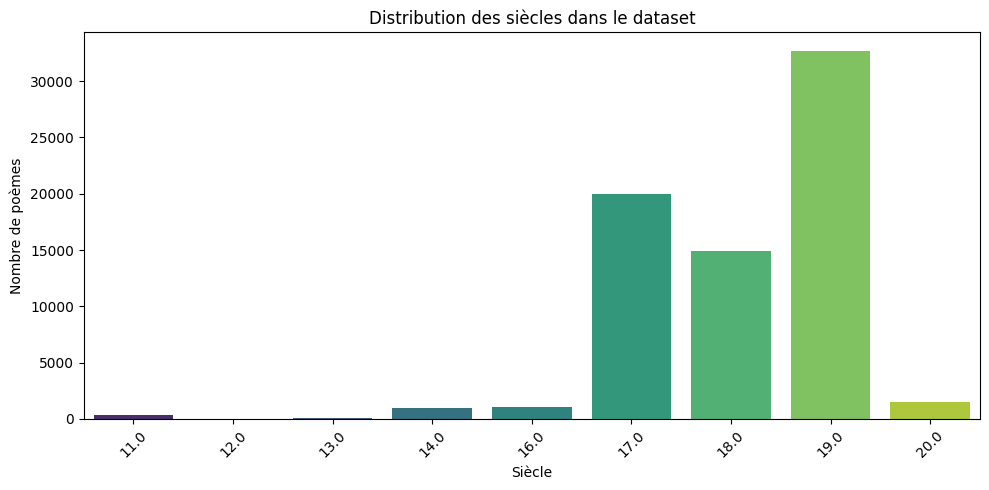

In [70]:
plt.figure(figsize=(10, 5))
sns.countplot(x="Creation", data=df, order=sorted(df["Creation"].unique()), palette="viridis")
plt.title("Distribution des siècles dans le dataset")
plt.xlabel("Siècle")
plt.ylabel("Nombre de poèmes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/6n/yr_zpd255sb5gdxm22_v7y6h0000gn/T/ipykernel_99256/2759500651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Poem_Length"] = df["Texte"].apply(lambda x: len(x.split()))


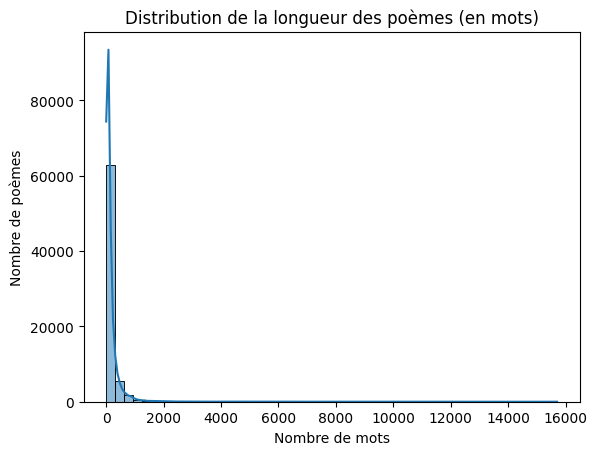

In [71]:
df["Poem_Length"] = df["Texte"].apply(lambda x: len(x.split()))
sns.histplot(df["Poem_Length"], bins=50, kde=True)
plt.title("Distribution de la longueur des poèmes (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de poèmes")
plt.show()

/var/folders/6n/yr_zpd255sb5gdxm22_v7y6h0000gn/T/ipykernel_99256/2567769514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Num_Tokens"] = df["Tokens"].apply(len)


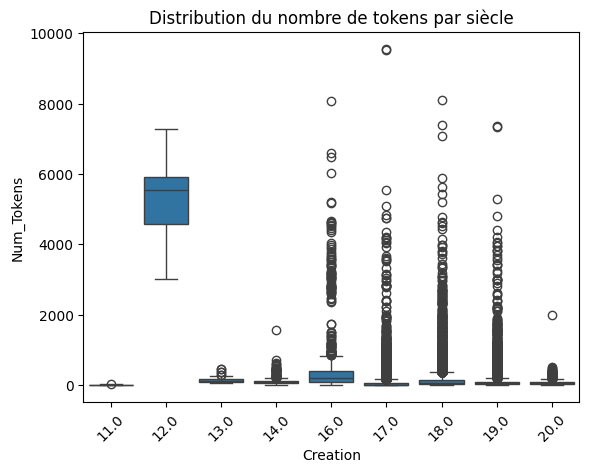

In [73]:
df["Num_Tokens"] = df["Tokens"].apply(len)
sns.boxplot(x="Creation", y="Num_Tokens", data=df)
plt.title("Distribution du nombre de tokens par siècle")
plt.xticks(rotation=45)
plt.show()

### Training Word 2 Vec on the tokenized texts

In [59]:
tokenized_poems = df["Tokens"].tolist()
model_df = Word2Vec(tokenized_poems, vector_size=100, window=5, min_count=2, workers=4)

model_df.save("word2vec_df.model")

### Embedding Text

In [60]:
def text_to_embedding(tokens, model, embedding_dim=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)


df["Embedding"] = df["Tokens"].apply(lambda x: text_to_embedding(x, model_df))

/var/folders/6n/yr_zpd255sb5gdxm22_v7y6h0000gn/T/ipykernel_99256/3614843057.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Embedding"] = df["Tokens"].apply(lambda x: text_to_embedding(x, model_df))


### Encoding Century and spliting data into test train

In [61]:
label_encoder = LabelEncoder()
df.loc[:, "Century_Label"] = label_encoder.fit_transform(df["Creation"])

x = torch.tensor(np.stack(df["Embedding"].values), dtype=torch.float32)
y = torch.tensor(df["Century_Label"].values, dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

### Defining the Model and TextDataset classes

In [ ]:
class LanguageModelNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_classes):
        super(LanguageModelNN, self).__init__()

        self.fc1 = nn.Linear(
            embedding_dim, hidden_size
        )
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
class LanguageModelNN_Dropout(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(100, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)
    
class TextDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.float32), torch.tensor(
            self.labels[idx], dtype=torch.long
        )

### Creating the data loaders

In [62]:
train_dataset = TextDataset(x_train, y_train)
val_dataset = TextDataset(x_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Defining the train and validation functions

In [19]:
def train(model, train_loader, loss_fn, optimizer, num_epochs=10):
    mlflow.start_run()  # Start an MLflow experiment

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0

        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)  # Forward pass
            loss = loss_fn(outputs, batch_y)  # Compute loss

            optimizer.zero_grad()  # Reset gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        mlflow.log_metric("train_loss", avg_loss, step=epoch)  # Log loss to MLflow
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    mlflow.pytorch.log_model(model, "model")  # Save trained model
    mlflow.end_run()  # End MLflow experiment


def validate(model, val_loader, label_encoder):
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())  # Move to CPU & store
            all_labels.extend(batch_y.cpu().numpy())  # Move to CPU & store

    # Convert numeric labels to class names (centuries)
    all_labels = label_encoder.inverse_transform(all_labels)
    all_predictions = label_encoder.inverse_transform(all_predictions)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    # Log to MLflow
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1)

    # Print metrics
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=label_encoder.classes_)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=[str(c) for c in label_encoder.classes_],
    )

    print(report)


### Creating model and hyperparameters

In [ ]:
embedding_dim = 100
hidden_size = 128
num_classes = len(df["Century_Label"].unique())

class_counts = np.bincount(df["Century_Label"])
class_weights = 1.0 / class_counts

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = LanguageModelNN(embedding_dim, hidden_size, num_classes)
# model = LanguageModelNN_Dropout(num_classes)
model.apply(initialize_weights)

loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


### Training and Validating model

Epoch 1/200, Loss: 0.7381
Epoch 2/200, Loss: 0.6408
Epoch 3/200, Loss: 0.6077
Epoch 4/200, Loss: 0.5878
Epoch 5/200, Loss: 0.5735
Epoch 6/200, Loss: 0.5620
Epoch 7/200, Loss: 0.5528
Epoch 8/200, Loss: 0.5446
Epoch 9/200, Loss: 0.5376
Epoch 10/200, Loss: 0.5316
Epoch 11/200, Loss: 0.5266
Epoch 12/200, Loss: 0.5204
Epoch 13/200, Loss: 0.5158
Epoch 14/200, Loss: 0.5112
Epoch 15/200, Loss: 0.5070
Epoch 16/200, Loss: 0.5049
Epoch 17/200, Loss: 0.4996
Epoch 18/200, Loss: 0.4971
Epoch 19/200, Loss: 0.4927
Epoch 20/200, Loss: 0.4901
Epoch 21/200, Loss: 0.4872
Epoch 22/200, Loss: 0.4846
Epoch 23/200, Loss: 0.4801
Epoch 24/200, Loss: 0.4773
Epoch 25/200, Loss: 0.4768
Epoch 26/200, Loss: 0.4738
Epoch 27/200, Loss: 0.4705
Epoch 28/200, Loss: 0.4684
Epoch 29/200, Loss: 0.4690
Epoch 30/200, Loss: 0.4642
Epoch 31/200, Loss: 0.4624
Epoch 32/200, Loss: 0.4599
Epoch 33/200, Loss: 0.4578
Epoch 34/200, Loss: 0.4568
Epoch 35/200, Loss: 0.4536
Epoch 36/200, Loss: 0.4521
Epoch 37/200, Loss: 0.4513
Epoch 38/2

2025/04/08 19:59:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Accuracy: 0.8008
Precision: 0.7955
Recall: 0.8008
F1-Score: 0.7908


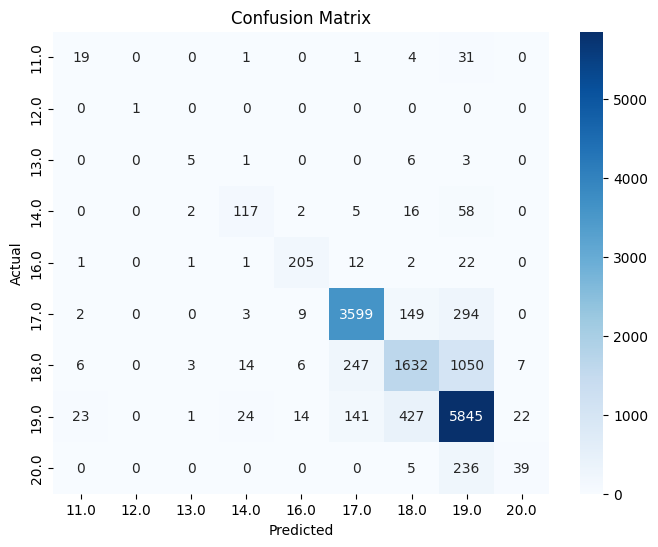

              precision    recall  f1-score   support

        11.0       0.37      0.34      0.36        56
        12.0       1.00      1.00      1.00         1
        13.0       0.42      0.33      0.37        15
        14.0       0.73      0.58      0.65       200
        16.0       0.87      0.84      0.85       244
        17.0       0.90      0.89      0.89      4056
        18.0       0.73      0.55      0.63      2965
        19.0       0.78      0.90      0.83      6497
        20.0       0.57      0.14      0.22       280

    accuracy                           0.80     14314
   macro avg       0.71      0.62      0.64     14314
weighted avg       0.80      0.80      0.79     14314



In [64]:
mlflow.end_run()    
train(model, train_loader, loss_fn, optimizer, num_epochs=200)
validate(model, val_loader, label_encoder)

## Testing

### Single inference

In [ ]:
row = 5000

input = df.loc[row, "Embedding"]
model.eval()

with torch.no_grad():
    input_tensor = torch.tensor(
        input, dtype=torch.float32
    )  # Convert input to PyTorch tensor
    output = model(input_tensor)
    prediction = torch.argmax(output).item()

print(f"Predicted: {label_encoder.classes_[prediction]}")
print(f"Actual: {label_encoder.classes_[df.loc[row, 'Century_Label']]}")


### Testing on dataset

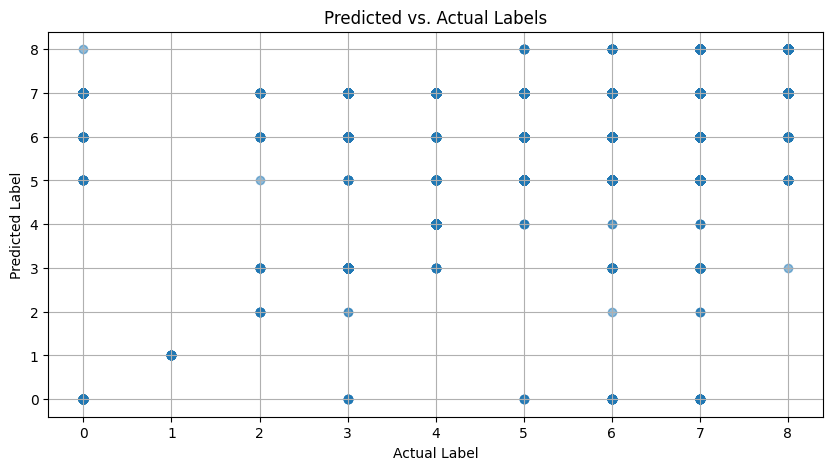

In [44]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store results
predicted_labels = []
actual_labels = []

# Disable gradient calculations for efficiency
with torch.no_grad():
    for index, row in df.iterrows():
        input_tensor = torch.tensor(row["Embedding"], dtype=torch.float32)
        output = model(input_tensor)
        prediction = torch.argmax(output).item()

        # Store results
        predicted_labels.append(prediction)
        actual_labels.append(row["Century_Label"])

# Convert to NumPy arrays for easier plotting
predicted_labels = np.array(predicted_labels)
actual_labels = np.array(actual_labels)

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(actual_labels, predicted_labels, alpha=0.5)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Predicted vs. Actual Labels")
plt.grid(True)
plt.show()


## HyperParam Optimization

In [ ]:
def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_choice = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])

    # Model creation with dropout
    model = LanguageModelNN_Dropout(num_classes=num_classes, dropout=dropout_rate)
    model = model.to(device)  # Move model to GPU

    # Dataset & DataLoader
    train_dataset = TextDataset(x_train, y_train)
    val_dataset = TextDataset(x_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    loss_fn = nn.CrossEntropyLoss(reduction="mean")

    # Optimizer selection
    if optimizer_choice == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_choice == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Early stopping parameters
    patience = 100
    best_val_acc = 0
    patience_counter = 0

    # Training
    for epoch in range(50):
        model.train()
        train_losses = []

        for batch_X, batch_y in train_loader:
            # Move tensors to the right device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Calculate average training loss for the epoch
        avg_train_loss = sum(train_losses) / len(train_losses)

        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        val_losses = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = loss_fn(outputs, batch_y)
                val_losses.append(loss.item())

                preds = torch.argmax(outputs, dim=1)

                # Move back to CPU for numpy conversion
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())

        # Calculate metrics
        current_val_acc = accuracy_score(all_labels, all_preds)
        avg_val_loss = sum(val_losses) / len(val_losses)

        # Log metrics (optional)
        print(
            f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {current_val_acc:.4f}"
        )

        # Report to Optuna for pruning
        trial.report(current_val_acc, epoch)

        # Handle pruning - stop this trial if it's not promising
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early stopping logic
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            patience_counter = 0
            # Save best model (optional)
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # Load best model weights before final evaluation (optional)
    if "best_model_state" in locals():
        model.load_state_dict(best_model_state)

    # Final evaluation on validation set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    final_acc = accuracy_score(all_labels, all_preds)

    return final_acc  # Return the best validation accuracy


def run_optuna_optimization(n_trials=20):
    # Create pruner
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,  # Number of trials to run before pruning
        n_warmup_steps=5,  # Number of epochs in each trial before pruning
        interval_steps=1,  # Report and check for pruning after each epoch
    )

    # Create study with the pruner
    study = optuna.create_study(
        direction="maximize", pruner=pruner, study_name="nlp_model_optimization"
    )

    # Run optimization
    study.optimize(objective, n_trials=n_trials)

    # Print results
    print("\nStudy statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(
        f"  Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}"
    )
    print(
        f"  Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}"
    )

    print("\nBest trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study


In [ ]:
study = run_optuna_optimization(n_trials=100)

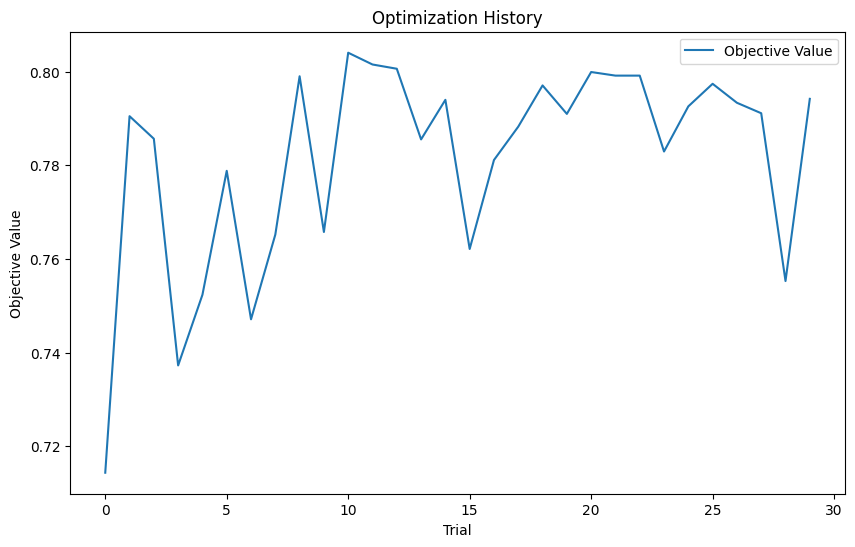

In [91]:
values = [trial.value for trial in study.trials]

plt.figure(figsize=(10, 6))
plt.plot(values, label="Objective Value")
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.title("Optimization History")
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

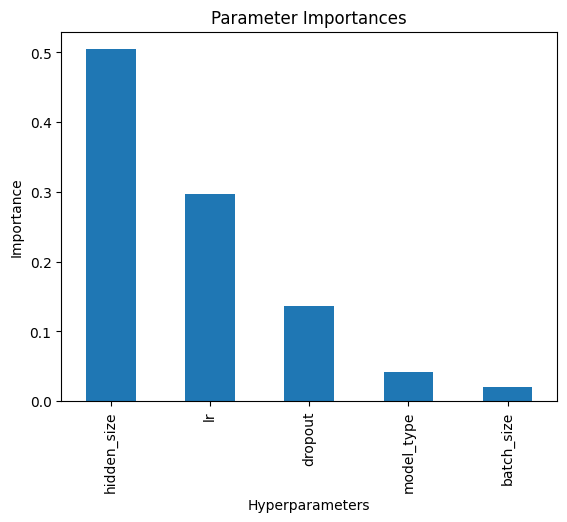

In [95]:
importances = optuna.importance.get_param_importances(study)
param_names = list(importances.keys())
importances_df = pd.DataFrame(
    list(importances.items()), columns=["Hyperparameter", "Importance"]
)


plt.figure(figsize=(10, 6))
importances_df.plot(kind="bar", x="Hyperparameter", y="Importance", legend=False)
plt.xlabel("Hyperparameters")
plt.ylabel("Importance")
plt.title("Parameter Importances")
plt.show()

In [ ]:
best_params = study.best_params

final_model = LanguageModelNN_Dropout(
    num_classes=num_classes, dropout=best_params["dropout"]
)
final_model = final_model.to(device)

# Setup with best hyperparameters
if best_params["optimizer"] == "Adam":
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_params["lr"])
else:
    final_optimizer = optim.AdamW(final_model.parameters(), lr=best_params["lr"])